# Libraries

In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

# Exploratory Data Analysis

**Reading the dataset**

In [2]:
df = pd.read_csv('sector_51_daily_aqi.csv', parse_dates=True, index_col='Date')

In [5]:
df.head(2)

,AQI
Date,
2020-03-05,73.0
2020-03-06,55.0


In [4]:
df.drop(columns = ['Unnamed: 0'],inplace= True)

**Checking for Null Values and then eradicating them**

In [6]:
df.isnull().sum()

AQI    2
dtype: int64

In [7]:
df['AQI'] = df['AQI'].ffill()

# Plotting the Dataset

<Axes: xlabel='Date'>

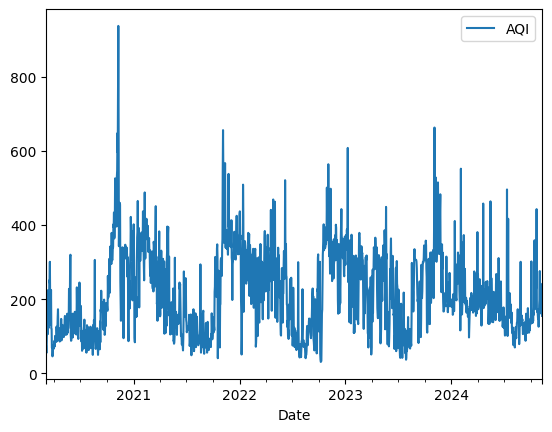

In [10]:
df.plot()

# Decomposing the time series 

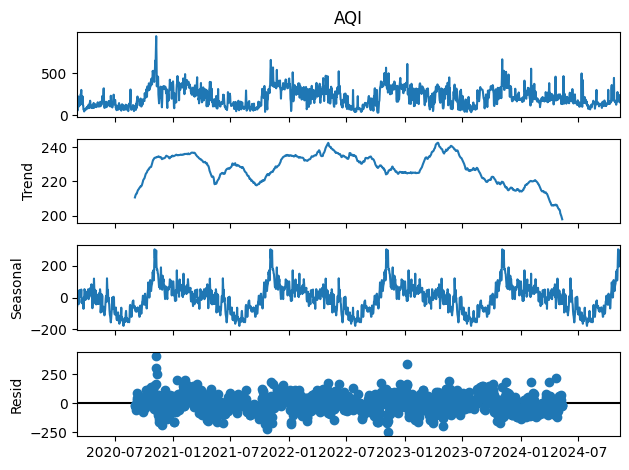

In [14]:
decomposition = seasonal_decompose(df['AQI'],model = 'additive',period = 365)
decomposition.plot()
plt.show()

Based on the the graphs, it is evident that the time series contains seasonality in it, Therefore, the time series is not stationary.

****But still let's try to conduct the Augmented Dickey-Fuller (ADF) test to check for stationarity.****

**PS: If your time series passes the Augmented Dickey-Fuller (ADF) test for stationarity based on the p-value, but you can visually observe seasonality in the plot, the series might still contain patterns that affect forecasting accuracy. Seasonality needs to be explicitly handled, even if the series is technically stationary.**

# Augmented Dickey-Fuller Test (ADF) 

In [17]:
# H0 : (Null Hypothesis) it is not stationary
# H1 : it is stationary
def adfuller_test(aqi):
    result = adfuller(aqi)
    labels = ['ADF Test Statistics', 'p-value', 'tags used', 'Number of observations used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value))
    if result[1] <= 0.05:
        print("Strong evidence against null hypothesis(H0) indicating that the series is staionary")
    else:
        print("Strong evidence supporting null hypothesis(H0) indicating that the series is not stationary")

In [18]:
adfuller_test(df['AQI'])

ADF Test Statistics : -4.27375921405694
p-value : 0.000493058729557918
tags used : 15
Number of observations used : 1695
Strong evidence against null hypothesis(H0) indicating that the series is staionary


**As discussed earlier, ADF only checks the constant behaviour of mean and variance across the data set, not taking into account the seasonality factor, Therefore, even though the series has passed the ADF test, it still isn't stationary. 
We need to take care of the seasonality**

# Now, in the following section we will be trying various methods to get rid of Seasonality in our Time series data

## 1. Seasonal Decomposition

**Using the same seasonal_decompose method that we used before, we will subtract the seasonal element from our data to try and counter the seasonality**

In [84]:
decomposition = seasonal_decompose(df['AQI'], model = 'additive', period = 365)
deseasonalized_data_1 = df['AQI'] - decomposition.seasonal

Text(0.5, 1.0, ' Deseasonalized Data')

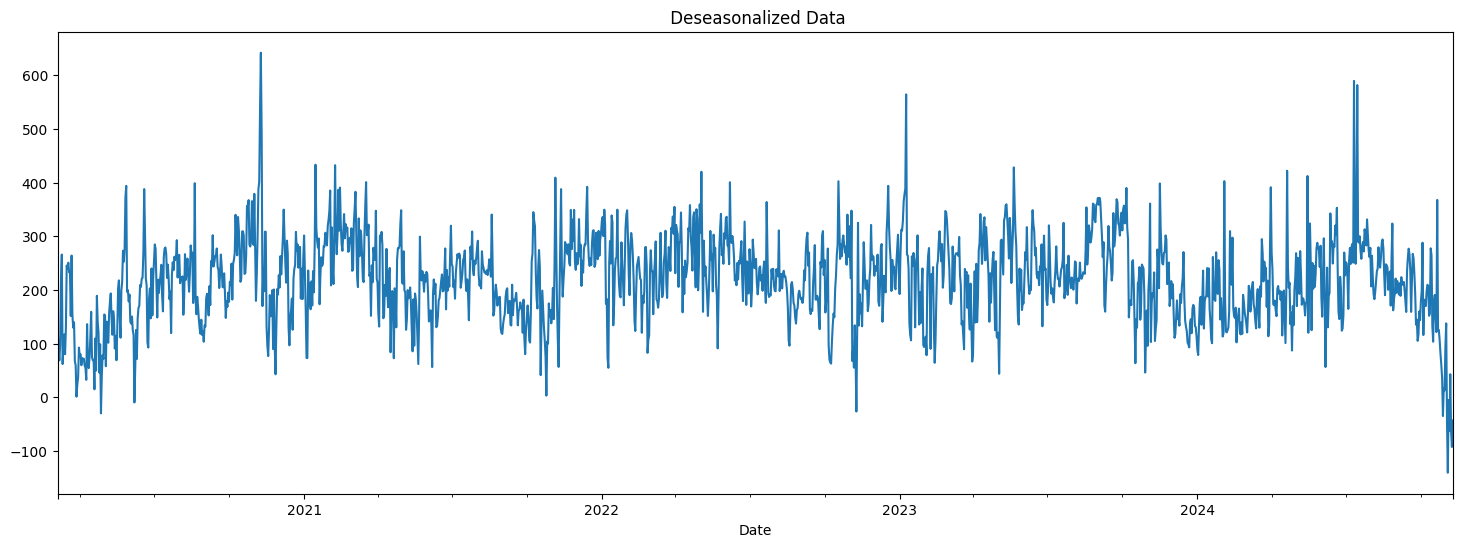

In [85]:
deseasonalized_data_1.plot(figsize = (18,6))
plt.title(" Deseasonalized Data") 

<Figure size 640x480 with 0 Axes>

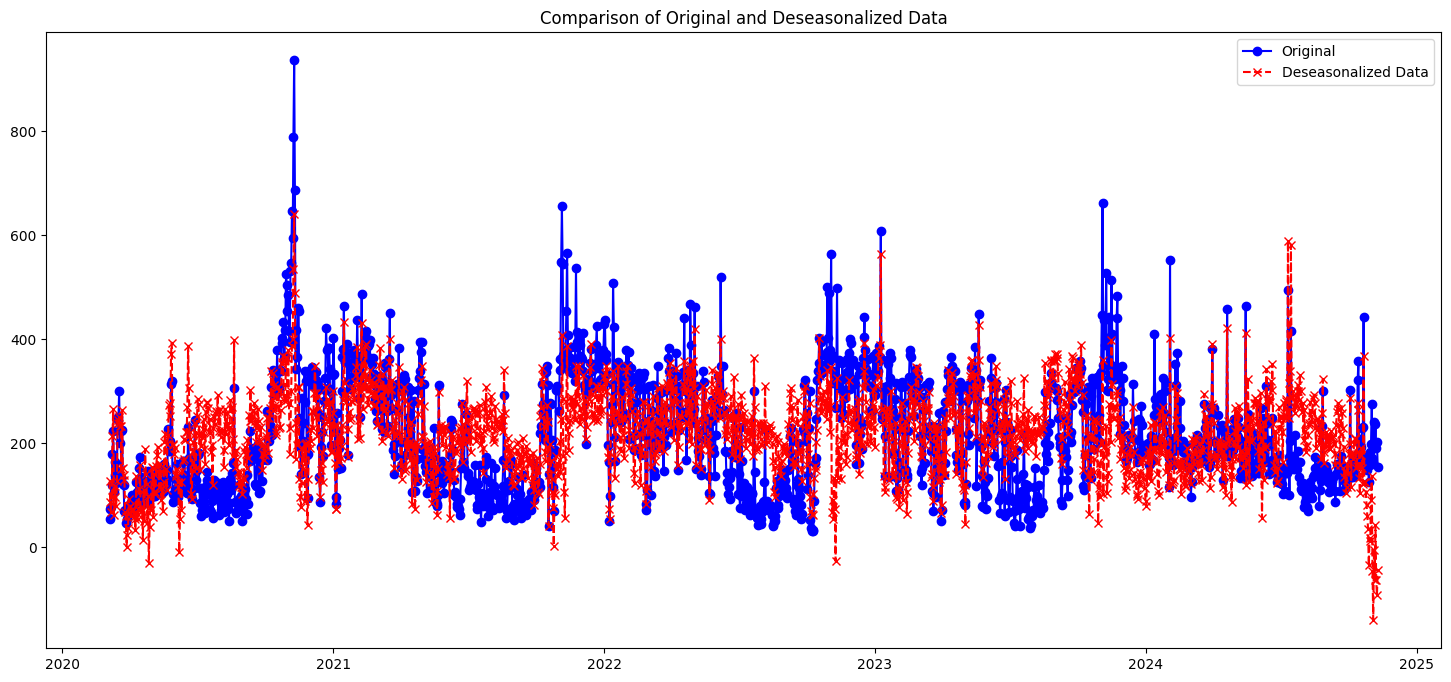

In [44]:
plt.clf()
plt.figure(figsize=(18,8))
plt.plot(df, label='Original', color='blue', linestyle='-', marker='o')
plt.plot(deseasonalized_data_1, label='Deseasonalized Data', color='red', linestyle='--', marker='x')
plt.legend()
plt.title("Comparison of Original and Deseasonalized Data") 
plt.show()

**As it is visible from the plottings (deseasonalized data plotting and the comparison between the original and the deseasonalized) that the seasonality has been removed from the series**

## 2. Seasonal Differencing

**Seasonal differencing removes seasonal patterns by subtracting the value from the same point in the previous season.**

In [87]:
seasonally_differenced_data = df['AQI'].diff(periods=365)
seasonally_differenced_data.dropna(inplace=True)


Text(0.5, 1.0, 'Seasonally Differenced data')

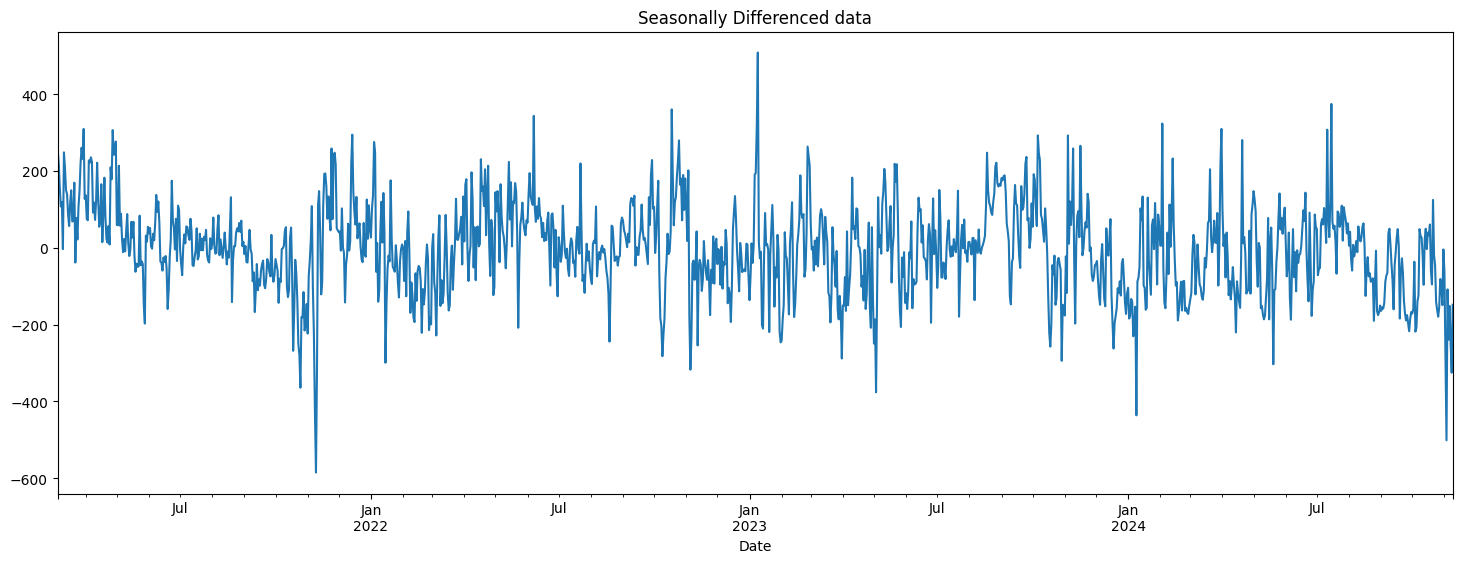

In [60]:
seasonally_differenced_data.plot(figsize=(18,6))
plt.title("Seasonally Differenced data")

**We can see clearly from the plotting that seasonality has succesfully been removed from the series**

**Although the seasonality is removed, the data has gone in the negative range, which primarily means that it is relatively smaller than the other data and not that its actual value is negative**

## 3. Moving Average Smoothing

**Use a moving average to smooth the seasonal fluctuations, effectively "averaging out" the seasonality.**

In [ ]:
rolling_mean = df['AQI'].rolling(window=365).mean()
deseasonalized_data_2 = df['AQI'] - rolling_mean
# Dropping the first 365 null values
deseasonalized_data_2.dropna()

Date
2021-03-04    110.295890
2021-03-05    117.594521
2021-03-06     61.994521
2021-03-07     21.567123
2021-03-08     15.271233
                 ...    
2024-11-05     -2.342466
2024-11-06     38.071233
2024-11-07     -8.243836
2024-11-08      4.646575
2024-11-09    -42.947945
Name: AQI, Length: 1347, dtype: float64

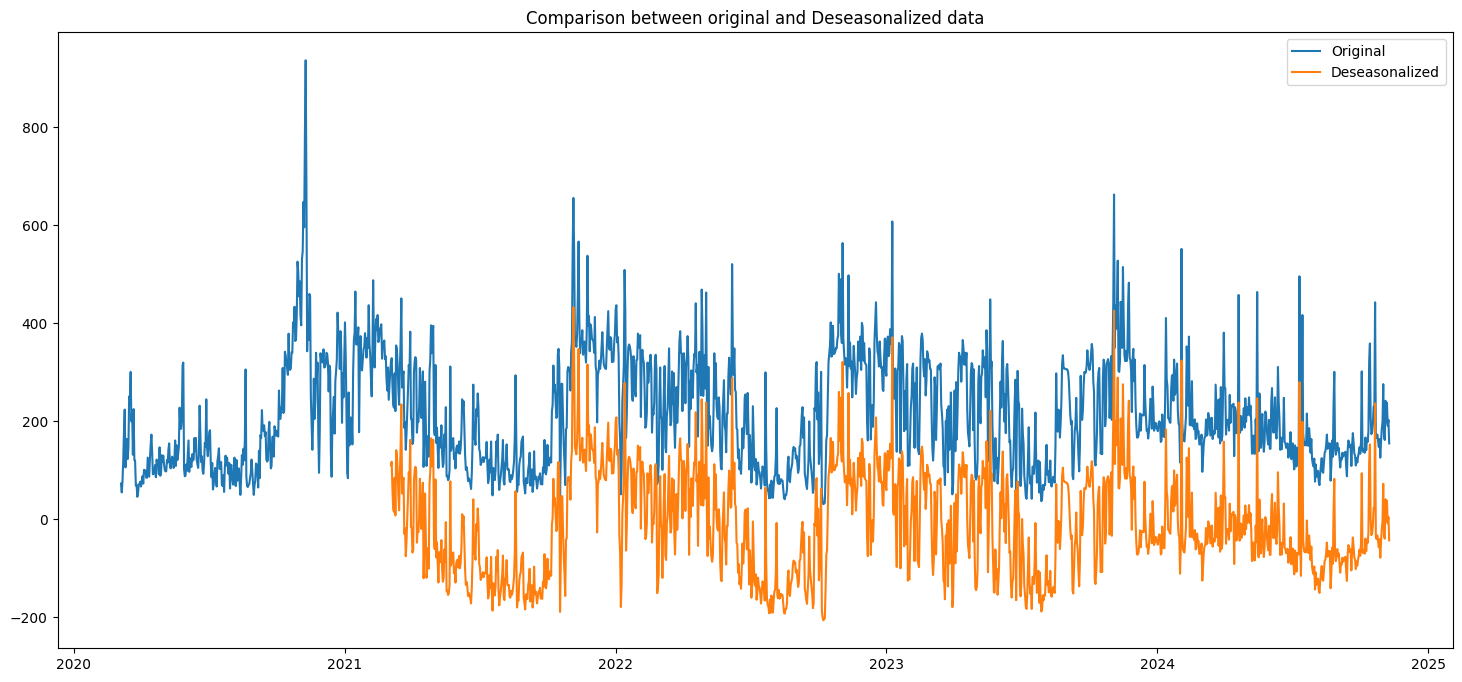

In [61]:
plt.figure(figsize=(18,8))
plt.plot(df['AQI'], label='Original')
plt.plot(deseasonalized_data_2, label='Deseasonalized')
plt.legend()
plt.title("Comparison between original and Deseasonalized data")
plt.show()

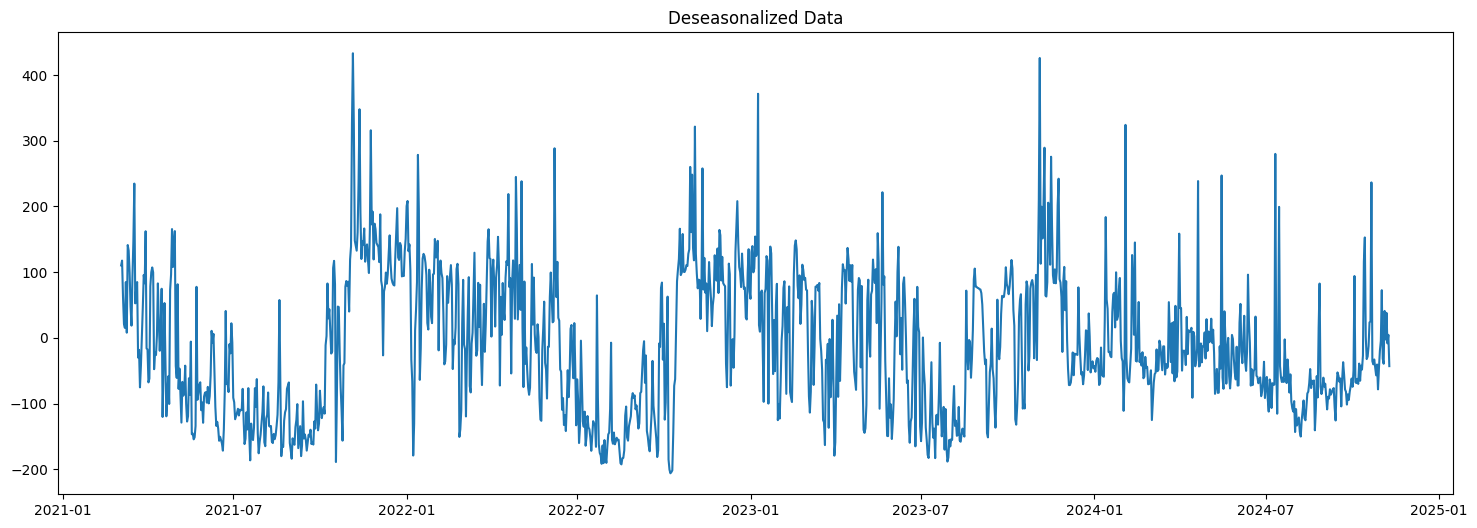

In [62]:
plt.figure(figsize=(18,6))
plt.plot(deseasonalized_data_2, label = "Deseasonalized data")
plt.title("Deseasonalized Data")
plt.show()

**It is visually evident that the seasonality has been removed.**

## 4. Resampling the Data

**Resample the data to a lower frequency to smooth out seasonal fluctuations.**

**--Daily to weekly**

In [80]:
weekly_data = df['AQI'].resample('W').mean()

Text(0.5, 1.0, 'Resampled data')

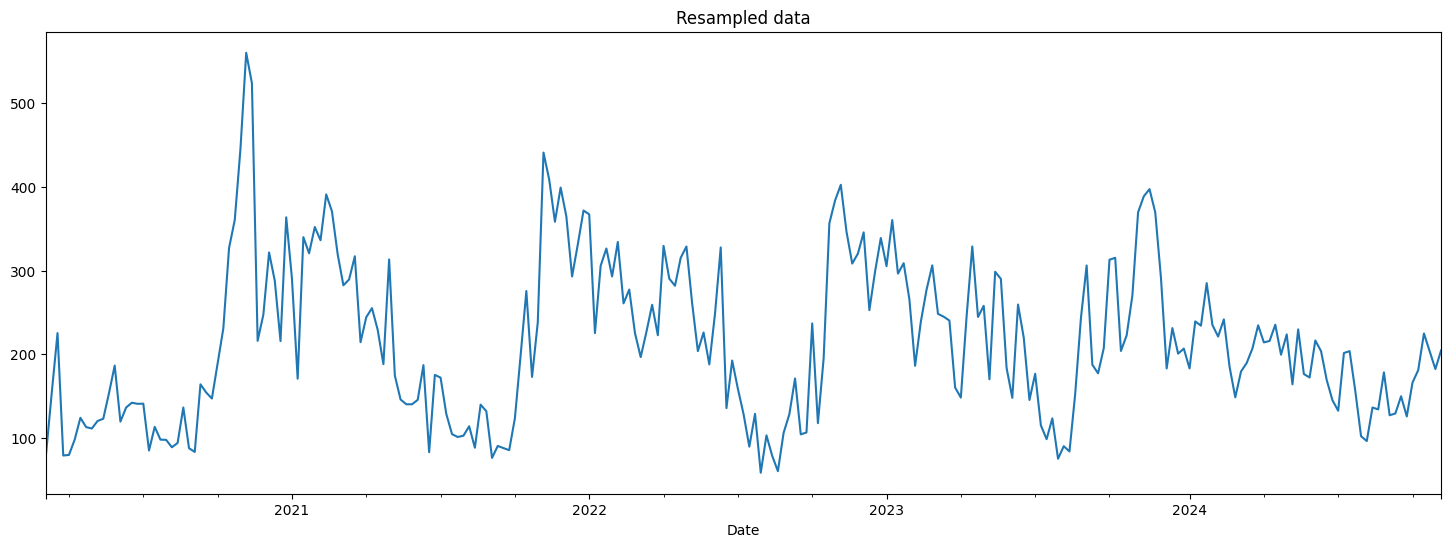

In [81]:
weekly_data.plot(figsize=(18,6))
plt.title("Resampled data")

**As we can see that resampling the data to a weekly format doesn't necessarily remove seasonality, however weekly data could be later used in SARIMA model to make predictions as using a Daily format in SARIMA is computationally too heavy.**

  #   Now in the next section we will create a model to make predictions
  #### We will be using the ARIMA ( Autoregressive Integrated Moving Average) model for the same.

#### For this we will be using the Seasonally Decomposed data that we had previously curated

#### Plotting ACF(Auto Correlation Function) and PACF (Partial Auto Correlation Function) for identifying the values of p and q that are to be used in the ARIMA

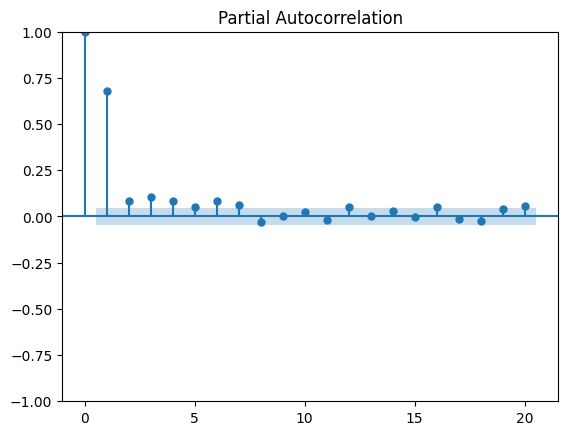

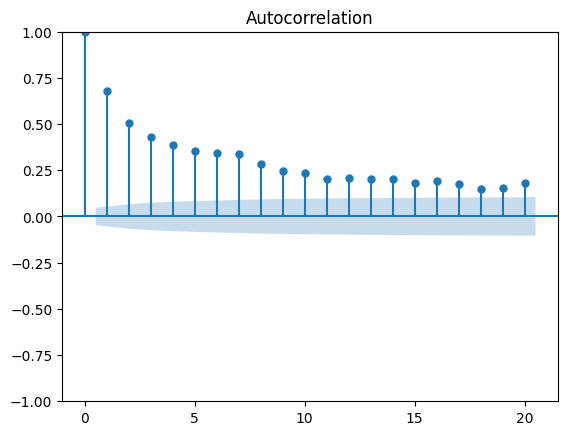

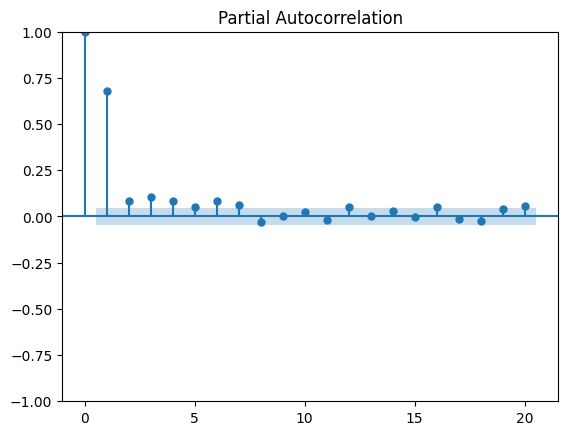

In [90]:
plot_acf(deseasonalized_data_1, lags=20)
plot_pacf(deseasonalized_data_1, lags=20)

In [109]:
train_size = int(len(deseasonalized_data_1) * 0.8)
train, test = deseasonalized_data_1[:train_size], deseasonalized_data_1[train_size:]

In [110]:
# Define ARIMA model
model = ARIMA(train, order=(2, 1, 2))
result = model.fit()

e:\ml_end_to_end_project\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [111]:
result.forecast(steps=30)

2023-12-03    217.491875
2023-12-04    220.562014
2023-12-05    223.409881
2023-12-06    224.098454
2023-12-07    225.482953
2023-12-08    225.352618
2023-12-09    226.203285
2023-12-10    225.803071
2023-12-11    226.447979
2023-12-12    225.970213
2023-12-13    226.525707
2023-12-14    226.037221
2023-12-15    226.545085
2023-12-16    226.068584
2023-12-17    226.544319
2023-12-18    226.087020
2023-12-19    226.536836
2023-12-20    226.100542
2023-12-21    226.527344
2023-12-22    226.111988
2023-12-23    226.517483
2023-12-24    226.122375
2023-12-25    226.507812
2023-12-26    226.132076
2023-12-27    226.498514
2023-12-28    226.141239
2023-12-29    226.489636
2023-12-30    226.149929
2023-12-31    226.481182
2024-01-01    226.158184
Freq: D, Name: predicted_mean, dtype: float64

In [ ]:
predictions = result.predict(start=test.index[0], end=test.index[-1])
rmse = np.sqrt(mean_squared_error(test, predictions))
print(f"RMSE: {rmse}")

RMSE: 87.99156024109716
